In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.chdir('/kaggle/working/')
os.makedirs('fig/', exist_ok=True)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-test-dataset-bot-iot/Train_Test_datasets_bot/UNSW_2018_IoT_Botnet.csv
/kaggle/input/ugr-16-sample/UGR_sample_5M.csv
/kaggle/input/graph-processing-for-machine/library/community/README.md
/kaggle/input/graph-processing-for-machine/library/community/community_louvain.py
/kaggle/input/graph-processing-for-machine/library/community/community_status.py
/kaggle/input/graph-processing-for-machine/library/community/__init__.py
/kaggle/input/graph-processing-for-machine/gpml/__init__.py
/kaggle/input/graph-processing-for-machine/gpml/metrics/graph_community.py
/kaggle/input/graph-processing-for-machine/gpml/metrics/graph_community.pyc
/kaggle/input/graph-processing-for-machine/gpml/metrics/__init__.py
/kaggle/input/graph-processing-for-machine/gpml/metrics/spectral_metrics.py
/kaggle/input/graph-processing-for-machine/gpml/visualisation/plot.pyc
/kaggle/input/graph-processing-for-machine/gpml/visualisation/plot.py
/kaggle/input/graph-processing-for-machine/gpml/visualisation

In [2]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.8 MB/s eta 0:00:00


## GPML Library

In [3]:
import os
os.chdir('/kaggle/input/graph-processing-for-machine/')

In [4]:
import gpml as gpml

## 1. Graph Representation

In [5]:
import pandas as pd
from gpml.visualisation.graphviz import extract_graph, show_graph, print_graph
from matplotlib import pyplot

df = pd.read_csv('/kaggle/input/train-test-dataset-bot-iot/Train_Test_datasets_bot/UNSW_2018_IoT_Botnet.csv')

### 1.1.1 Using show_graph functionality

connectivity_graph, _attack_list, _attack_labels = extract_graph(df, 'ip', 'attack', 'saddr', 'daddr','sport', 'dport', 0, 0)
show_graph(connectivity_graph)

### 1.1.2 Using print_graph functionality

In [6]:
#print_graph(df, 'ip', 'attack', 'saddr', 'daddr','sport', 'dport')

## 2. Spectral Metrics

### 1.2.1 Timeseries extraction

from gpml.data_preparation.time_series_extractor import time_series_extractor

features_list = ['stime', 'datetime', 'saddr', 'daddr','sport', 'dport', 
            'pkts', 'bytes', 'rate','attack', 'category', 'subcategory',
            'weight', 'dur', 'mean', 'sum', 'min','max', 'spkts', 
            'dpkts', 'srate', 'drate']
sortby_list = ['stime']
groupby_list = ['stime', 'datetime', 'saddr', 'daddr']
aggregation_dict = {'pkts': 'sum', 'bytes': 'sum', 'attack': 'first',
                    'category': 'first', 'subcategory': 'first','rate': 'mean',
                    'dur': 'mean', 'mean': 'mean','sum': 'mean', 'min': 'mean',
                    'max': 'mean','spkts': 'mean', 'srate': 'mean', 'drate': 'mean',
                    'weight': 'sum'}

ts = time_series_extractor(df, 'stime', 's',features_list, sortby_list, groupby_list,aggregation_dict)

### 1.2.2 Spectral metrics extraction

print(ts.head(5))

from gpml.metrics.spectral_metrics import spectral_metrics_extractor

%%capture
spectral_df = spectral_metrics_extractor(ts, 'stime', 'saddr', 'daddr', 
                                         'pkts', 'bytes', 'rate', 'attack')

print(spectral_df.head(5))

### 1.2.3 Evaluation of spectral metrics using XGBoost Classifier

map_dict = {
    'Normal': 0,
    'OS_Fingerprint': 1,
    'UDP': 2,
    'Keylogging': 3,
    'Service_Scan': 4,
    'Data_Exfiltration': 5  
}

print(spectral_df['attack'].value_counts())

spectral_df.info()
spectral_df.isnull().sum()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load your data (replace this with your actual data loading code)
X = spectral_df.drop('attack', axis=1)
y = spectral_df['attack']

# Convert the 'label' column to integers if it's of object type
if y.dtype == object:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

# Handle non, infinite, and large values by setting them to 10^5
X[np.isnan(X) | np.isinf(X) | (X > 1e5)] = 1e5

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train = X_train[['t1_m1_pkts', 't1_m2_pkts', 't1_m3_pkts', 't1_m4_pkts', 't2_m1_pkts', 't2_m2_pkts', 't2_m3_pkts', 't2_m4_pkts', 't1_m1_bytes', 't1_m2_bytes', 't1_m3_bytes', 't1_m4_bytes', 't2_m1_bytes', 't2_m2_bytes', 't2_m3_bytes', 't2_m4_bytes', 't1_m1_rate', 't1_m2_rate', 't1_m3_rate', 't1_m4_rate', 't2_m1_rate', 't2_m2_rate', 't2_m3_rate', 't2_m4_rate', 'pkts', 'bytes', 'rate']]
X_test = X_test[['t1_m1_pkts', 't1_m2_pkts', 't1_m3_pkts', 't1_m4_pkts', 't2_m1_pkts', 't2_m2_pkts', 't2_m3_pkts', 't2_m4_pkts', 't1_m1_bytes', 't1_m2_bytes', 't1_m3_bytes', 't1_m4_bytes', 't2_m1_bytes', 't2_m2_bytes', 't2_m3_bytes', 't2_m4_bytes', 't1_m1_rate', 't1_m2_rate', 't1_m3_rate', 't1_m4_rate', 't2_m1_rate', 't2_m2_rate', 't2_m3_rate', 't2_m4_rate', 'pkts', 'bytes', 'rate']]

"""
from xgboost import XGBClassifier

clf = XGBClassifier(tree_method="auto") # gpu_hist
clf=clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
"""

In [7]:
from sklearn.metrics import (precision_score, recall_score, accuracy_score, f1_score, 
                             balanced_accuracy_score, matthews_corrcoef, zero_one_loss, 
                             confusion_matrix, classification_report)
import pandas as pd
import numpy as np
import time

# Initialize evaluation dataframes
eval_df = pd.DataFrame(columns=['Classifier', 'Precision', 'Recall', 'TNR', 'TPR', 'Accuracy', 
                                'F1', 'Balanced Accuracy', 'MCC', 'Zero-One Loss', 'Fit Time', 'Predict Time'])
cm_df = pd.DataFrame(columns=['Classifier', 'Confusion Matrix', 'Classification Report'])
df_scores = pd.DataFrame(columns=['Attack Type', 'Label', 'Feature Set', 'Classifier', 'F1 Score', 
                                  'Balanced Accuracy', 'MCC', 'Precision', 'Recall', 'Other'])

from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import numpy as np

def classwise_mcc(y_test, pred_target, num_classes):
    class_mcc = {}
    
    for cls in range(num_classes):
        true_positive = np.sum((y_test == cls) & (pred_target == cls))
        false_positive = np.sum((y_test != cls) & (pred_target == cls))
        true_negative = np.sum((y_test != cls) & (pred_target != cls))
        false_negative = np.sum((y_test == cls) & (pred_target != cls))
        
        numerator = (true_positive * true_negative) - (false_positive * false_negative)
        denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
        
        # Handling the case when the denominator is zero
        if denominator == 0:
            mcc = 0
        else:
            mcc = numerator / denominator
        
        class_mcc[cls] = mcc
    
    return class_mcc
    
def classwise_balanced_accuracy(y_test, pred_target, num_classes):
    class_balanced_accuracy = {}
    
    for cls in range(num_classes):
        true_positive = np.sum((y_test == cls) & (pred_target == cls))
        false_positive = np.sum((y_test != cls) & (pred_target == cls))
        true_negative = np.sum((y_test != cls) & (pred_target != cls))
        false_negative = np.sum((y_test == cls) & (pred_target != cls))
        
        sensitivity = true_positive / (true_positive + false_negative)
        specificity = true_negative / (true_negative + false_positive)
        
        balanced_accuracy = (sensitivity + specificity) / 2
        class_balanced_accuracy[cls] = balanced_accuracy
    
    return class_balanced_accuracy
    
def get_tnr_tpr(y_test, pred_target):
    
    tn=0
    tp=0
    fn=0
    fp=0

    i=0
    y_test_list=list(y_test)
    
    for i in range(len(y_test)):
        if(pred_target[i] == 0):
            if(y_test_list[i] == pred_target[i]):
                tn += 1
            else:
                fn += 1
        else:
            if(y_test_list[i] == pred_target[i]):
                tp += 1
            else:
                fp += 1
    if(tn+fp == 0):
        tnr = 1
    else:
        tnr = tn/(tn+fp)
    if (tp+fn == 0):
        tpr = 1
    else:
        tpr = tp/(tp+fn)

    return tnr,tpr
    
def eval_xgb(clf, X_test, y_test, fit_time, pred_time, verbose=True):
    # Predict and calculate metrics
    pred_target = clf.predict(X_test)
    tnr, tpr = get_tnr_tpr(y_test, pred_target)  # Assumes a function to calculate TNR and TPR

    # Populate eval_df with overall metrics
    eval_df.loc[len(eval_df.index)] = [type(clf).__name__,
                                       precision_score(y_test, pred_target, average='weighted',zero_division=0.0),
                                       recall_score(y_test, pred_target, average='weighted',zero_division=0.0),
                                       tnr,
                                       tpr,
                                       accuracy_score(y_test, pred_target),
                                       f1_score(y_test, pred_target, average='weighted',zero_division=0.0),
                                       balanced_accuracy_score(y_test, pred_target),
                                       matthews_corrcoef(y_test, pred_target),
                                       zero_one_loss(y_test, pred_target),
                                       fit_time,
                                       pred_time]

    # Populate cm_df with confusion matrix and classification report
    cm_df.loc[len(cm_df.index)] = [type(clf).__name__,
                                   confusion_matrix(y_test, pred_target),
                                   classification_report(y_test, pred_target)]

    # Class-specific scores for certain labels (example labels: 2, 4, 1, 3)
    num_classes = len(np.unique(y_test))
    class_balanced_accuracies = classwise_balanced_accuracy(y_test, pred_target, num_classes)
    class_mcc = classwise_mcc(y_test, pred_target, num_classes)

    for label, attack_type in zip([2, 4, 1, 3], ["DDoS", "ScanService", "OS Fingerprint", "Keylogging"]):
        if str(label) in classification_report(y_test, pred_target, output_dict=True):
            report = classification_report(y_test, pred_target, output_dict=True).get(str(label))
            df_scores.loc[len(df_scores.index)] = [attack_type,
                                                   label,
                                                   'TW (common features except t_features with smetrics)',
                                                   type(clf).__name__,
                                                   report['f1-score'],
                                                   class_balanced_accuracies.get(label, "Class not found"),
                                                   class_mcc.get(label, "Class not found"),
                                                   report['precision'],
                                                   report['recall'],
                                                   6]

    if verbose == True:
        print(eval_df)
        print(eval_df.loc[eval_df.Classifier == type(clf).__name__])
        print(cm_df)
"""
# Example usage:
fit_start = time.time()
clf = XGBClassifier(tree_method="auto")  # Change to "gpu_hist" if GPU acceleration is needed
clf.fit(X_train, y_train)
fit_time = time.time() - fit_start

pred_start = time.time()
y_pred = clf.predict(X_test)
pred_time = time.time() - pred_start

eval_xgb(clf, X_test, y_test, fit_time, pred_time)
"""

'\n# Example usage:\nfit_start = time.time()\nclf = XGBClassifier(tree_method="auto")  # Change to "gpu_hist" if GPU acceleration is needed\nclf.fit(X_train, y_train)\nfit_time = time.time() - fit_start\n\npred_start = time.time()\ny_pred = clf.predict(X_test)\npred_time = time.time() - pred_start\n\neval_xgb(clf, X_test, y_test, fit_time, pred_time)\n'

In [8]:
bracket_a = "{Baseline, Graph, Graph community, DGC}"
ytick_brack = {0.7,0.75,0.8,0.85,0.9,0.95,1}
metrics = [('MCC','blue'),('Balanced Accuracy','orange'),('TPR','green'),('TNR','cyan')]
def result_to_latex(result,multiclass,metrics,bracket_approaches,title,filename):
    #start
    start_string = "\\begin{figure*}\n\\caption{"+title + "}\n\\label{fig:"+filename+"}\n\\begin{tabular}{ccc}\n\\multicolumn{3}{c}{} \\\\\n"
    colorbank = ['green','orange','violet','magenta','olive','blue','red','teal','brown','darkgray','lime','black','yellow']
    # Binary prediction
    tikz_header = "\\resizebox{0.33\linewidth}{!}{\\begin{tikzpicture}\n\\begin{axis}[xlabel={Binary prediction},\nylabel={Score},\nxmin=0,\nxmax=3,\nymin="+str(list(ytick_brack)[0])+",\nymax="+str(list(ytick_brack)[-1])+",\nxtick={0,1,2,3},\nxticklabels="+ str(bracket_approaches)+",\nytick="+str(ytick_brack)+",\nlegend pos=south east,\nlegend style={fill=none},\nymajorgrids=true,\ngrid style=dashed]\n"
    plot_string =""
    for elm in metrics:
        count = 0
        str_datapoint = ""
        for row in result[elm[0]]:
            str_datapoint = str_datapoint + '(' +str(count)+","+str(row) + ')'
            count = count + 1
        plot_string = plot_string + "\\addplot[\n,color="+elm[1]+",\nmark=square,\n]\ncoordinates {\n"+str_datapoint + "\n};\n\\addlegendentry{"+elm[0]+"}\n"
    tikz_ender = "\\end{axis}\n\\end{tikzpicture}}\n"
    plot_diff_binary = tikz_header+plot_string+tikz_ender
    
    #Prediction and fitting times
    
    tikz_header2 = "\\resizebox{0.33\linewidth}{!}{\\begin{tikzpicture}\n\\begin{axis}[xlabel={Time performances},\nylabel={Time(s)},\nxmin=0,\nxmax=3,\nymin="+str(min(result["Predict Time"]))+",\nymax="+str(max(result["Fit Time"]))+",\nxtick={0,1,2,3},\nxticklabels="+ str(bracket_approaches)+",\nytick={"+str(min(result["Predict Time"]))+","+str(max(result["Fit Time"]))+"},\nlegend pos=south east,\nlegend style={fill=none},\nymajorgrids=true,\ngrid style=dashed]\n"
    
    pred_string=""
    fit_string=""
    count = 0
    for index,row in result.iterrows():
        pred_string = pred_string + '(' +str(count)+","+str(row["Predict Time"]) + ')'
        fit_string = fit_string + '(' +str(count)+","+str(row["Fit Time"]) + ')'
        count = count + 1
    plot_string2 = "\\addplot[\n,color=blue,\nmark=square,\n]\ncoordinates {\n"+pred_string + "\n};\n\\addlegendentry{Prediction time}\n"
    plot_string2 = plot_string2 + "\\addplot[\n,color=red,\nmark=square,\n]\ncoordinates {\n"+fit_string + "\n};\n\\addlegendentry{Fitting time}\n"
    plot_diff_time = tikz_header2 + plot_string2 + tikz_ender

    # Multiclass prediction
    tikz_header3 = "\\resizebox{0.33\linewidth}{!}{\\begin{tikzpicture}\n\\begin{axis}[xlabel={Multiclass Prediction},\nylabel={F1\_Score},\nxmin=0,\nxmax=3,\nymin="+str(list(ytick_brack)[0])+",\nymax="+str(list(ytick_brack)[-1])+",\nxtick={0,1,2,3},\nxticklabels="+ str(bracket_approaches)+",\nytick="+str(ytick_brack)+",\nlegend pos=south east,\nlegend style={fill=none},\nymajorgrids=true,\ngrid style=dashed]\n"
    plot_string3 = ""
    extra_count=0
    for col in multiclass:
        count = 0
        str_datapoint = ""
        for elm in multiclass[col]:
            str_datapoint = str_datapoint + '(' +str(count)+","+str(elm) + ')'
            count = count + 1
        plot_string3 = plot_string3 + "\\addplot[\n,color="+colorbank[extra_count]+",\nmark=square,\n]\ncoordinates {\n"+str_datapoint + "\n};\n\\addlegendentry{"+col+"}\n"
        extra_count = extra_count+1
    plot_diff_multi = tikz_header3+plot_string3+tikz_ender
    
    #End and completion
    
    end_string = "\\end{tabular}\n\\end{figure*}"
    latex_text = start_string + plot_diff_binary + plot_diff_multi + plot_diff_time + end_string
    with open('/kaggle/working/'+filename+'.txt', 'w') as f:
        f.write(latex_text)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plotting the evaluation metrics as a histogram
metrics = eval_df.columns[1:-2]  # Selecting metrics columns excluding 'Classifier', 'Fit Time', 'Predict Time'
values = eval_df.iloc[0, 1:-2].values  # Extracting metric values

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, align='center', alpha=0.7)
plt.xlabel('Metric Value')
plt.title(f'Evaluation Metrics for {eval_df.iloc[0, 0]}')
plt.xlim(0, 1)  # Assuming metrics are between 0 and 1 for clarity
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## 3. Community graph metrics

In [9]:
df = pd.read_csv('/kaggle/input/ugr-16-sample/UGR_sample_5M.csv')

In [10]:
from datetime import date, timedelta, datetime
from gpml.data_preparation import data_frame_handler as ins_data
community_df = ins_data.insert_metrics_to_dataframe(df, timedelta(minutes=5), 'Date time', ['Source IP'], ['Destination IP'], 'Label', 'ip5',
                                community_strategy='louvain',continuity=True)
community_df = ins_data.insert_metrics_to_dataframe(community_df, timedelta(minutes=20), 'Date time', ['Source IP'], ['Destination IP'], 'Label', 'ip20',
                                community_strategy='louvain',continuity=True)
community_df = ins_data.insert_metrics_to_dataframe(community_df, timedelta(minutes=5), 'Date time', ['Source IP','Source Port'], ['Destination IP','Destination Port'], 'Label', 'ipport5',
                                community_strategy='louvain',continuity=True)
community_df = ins_data.insert_metrics_to_dataframe(community_df, timedelta(minutes=20), 'Date time', ['Source IP','Source Port'], ['Destination IP','Destination Port'], 'Label', 'ipport20',
                                community_strategy='louvain',continuity=True)

First_graph generated and metrics computed
5000000
First_graph generated and metrics computed
5000000
First_graph generated and metrics computed
5000000
First_graph generated and metrics computed
5000000


In [11]:
community_df['attack'] = community_df['Label']
community_df['attack'] = community_df['attack'].replace(["background","blacklist"], 0)
community_df['attack'] = community_df['attack'].replace(["nerisbotnet","dos","scan44","scan11","anomaly-spam"], 1)

/tmp/ipykernel_16/1723142284.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  community_df['attack'] = community_df['attack'].replace(["nerisbotnet","dos","scan44","scan11","anomaly-spam"], 1)


In [12]:
ugr_map_dict = {
    'background': 0,
    'blacklist': 0,
    'anomaly-spam': 1,
    'dos': 2,
    'scan11': 3,
    'scan44': 4,
    'nerisbotnet': 5
}

def get_columns_graph(names):
    list_of_metrics = []
    for name in names:
        list_of_metrics.append('average_degree_g_'+ name)
        list_of_metrics.append('density_g_'+ name)
    return list_of_metrics
def get_columns_community(names):
    list_of_metrics = []
    for name in names:
        list_of_metrics.append('community_'+name)
        list_of_metrics.append('Nb_of_nodes_c_'+name)
        list_of_metrics.append('Nb_of_edges_c_'+name)
        list_of_metrics.append('average_degree_c_'+name)
        list_of_metrics.append('anchor_'+name)
        list_of_metrics.append('density_c_'+name)
        list_of_metrics.append('edges_dist_'+name)
        list_of_metrics.append('externality_'+name)
        list_of_metrics.append('conductance_'+name)
        list_of_metrics.append('expansion_'+name)
        list_of_metrics.append('mean_community_size_'+name)
        list_of_metrics.append('NED_'+name)
        list_of_metrics.append('NED_index_'+name)
    return list_of_metrics

base_col =  ['Duration','Bytes','Packets','Source Port','Destination Port','ToS']
g_col = get_columns_graph(['ip5']) + get_columns_graph(['ip20']) + get_columns_graph(['ipport5']) + get_columns_graph(['ipport20'])
c_col = get_columns_community(['ip5']) +  get_columns_community(['ip20']) +  get_columns_community(['ipport5']) +  get_columns_community(['ipport20'])
dc_col = ['last_stability_ip5','stability_ip5','delta_density_ip5','delta_Node_ip5','delta_Degree_ip5','delta_expansion_ip5',
          'last_stability_ip20','stability_ip20','delta_density_ip20','delta_Node_ip20','delta_Degree_ip20','delta_expansion_ip20',
          'last_stability_ipport5','stability_ipport5','delta_density_ipport5','delta_Node_ipport5','delta_Degree_ipport5','delta_expansion_ipport5',
          'last_stability_ipport20','stability_ipport20','delta_density_ipport20','delta_Node_ipport20','delta_Degree_ipport20','delta_expansion_ipport20']
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load your data (replace this with your actual data loading code)
X = community_df.drop('attack', axis=1)
y = community_df['attack']

# Convert the 'label' column to integers if it's of object type
if y.dtype == object:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)




/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.38852	validation_1-aucpr:0.38720
[1]	validation_0-aucpr:0.39566	validation_1-aucpr:0.39421
[2]	validation_0-aucpr:0.39856	validation_1-aucpr:0.39657
[3]	validation_0-aucpr:0.40099	validation_1-aucpr:0.39921
[4]	validation_0-aucpr:0.40122	validation_1-aucpr:0.39938
[5]	validation_0-aucpr:0.40389	validation_1-aucpr:0.40223
[6]	validation_0-aucpr:0.40663	validation_1-aucpr:0.40409
[7]	validation_0-aucpr:0.40845	validation_1-aucpr:0.40567
[8]	validation_0-aucpr:0.40848	validation_1-aucpr:0.40646
[9]	validation_0-aucpr:0.40916	validation_1-aucpr:0.40694
[10]	validation_0-aucpr:0.41675	validation_1-aucpr:0.41430
[11]	validation_0-aucpr:0.41837	validation_1-aucpr:0.41607
[12]	validation_0-aucpr:0.41955	validation_1-aucpr:0.41683
[13]	validation_0-aucpr:0.42034	validation_1-aucpr:0.41733
[14]	validation_0-aucpr:0.42174	validation_1-aucpr:0.41836
[15]	validation_0-aucpr:0.42310	validation_1-aucpr:0.41935
[16]	validation_0-aucpr:0.42379	validation_1-aucpr:0.41995
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.38851573002724915, 0.39565676534010563, 0.39856459294698116, 0.4009941587275478, 0.4012195995385097, 0.40388649332653703, 0.4066260256925392, 0.40844968615364075, 0.4084830958548029, 0.4091596607548028, 0.4167488524686991, 0.41836754278367866, 0.4195507860114098, 0.42033856043576234, 0.4217401690352447, 0.42310237121421945, 0.42379045423481554, 0.4240064623164192, 0.4244003890740735, 0.4247089038470814, 0.4260395574708929, 0.42646511387481917, 0.42807592473277123, 0.4283294733250054, 0.4294140653972207, 0.4294871886393736, 0.42963238278187443, 0.4298297045870674, 0.43159869063699224, 0.4316287758686958, 0.4319749632619519, 0.43205913896087317, 0.4325968475220513, 0.43281444124824126, 0.4329074872720034, 0.4337316315152811, 0.4337605626250873, 0.4340725934738331, 0.434608490308126, 0.4348327531868448, 0.4352255657604196, 0.4352664315461828, 0.4354354793938407, 0.43602480008337074, 0.4369378087175786, 0.43699264692956274, 0.43706265957084933, 0.

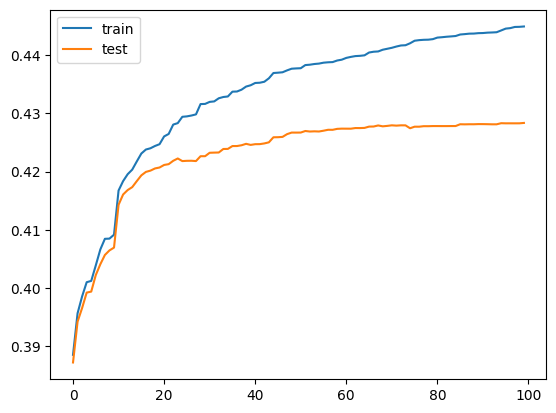

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.38410	validation_1-aucpr:0.38979
[1]	validation_0-aucpr:0.39071	validation_1-aucpr:0.39606
[2]	validation_0-aucpr:0.39667	validation_1-aucpr:0.40213
[3]	validation_0-aucpr:0.39891	validation_1-aucpr:0.40423
[4]	validation_0-aucpr:0.39972	validation_1-aucpr:0.40495
[5]	validation_0-aucpr:0.39972	validation_1-aucpr:0.40485
[6]	validation_0-aucpr:0.40186	validation_1-aucpr:0.40655
[7]	validation_0-aucpr:0.40527	validation_1-aucpr:0.40816
[8]	validation_0-aucpr:0.40910	validation_1-aucpr:0.41206
[9]	validation_0-aucpr:0.40983	validation_1-aucpr:0.41292
[10]	validation_0-aucpr:0.41388	validation_1-aucpr:0.41744
[11]	validation_0-aucpr:0.41383	validation_1-aucpr:0.41709
[12]	validation_0-aucpr:0.41464	validation_1-aucpr:0.41797
[13]	validation_0-aucpr:0.41117	validation_1-aucpr:0.41598
[14]	validation_0-aucpr:0.41465	validation_1-aucpr:0.41894
[15]	validation_0-aucpr:0.41616	validation_1-aucpr:0.42044
[16]	validation_0-aucpr:0.41703	validation_1-aucpr:0.42111
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.3840978200032999, 0.39071120744990084, 0.39667006820761713, 0.39890688868895574, 0.3997218430358419, 0.399720553211411, 0.401856535624573, 0.4052687315223276, 0.40909726168309535, 0.4098346822012714, 0.4138804751461445, 0.41382922677435063, 0.4146415203065566, 0.4111727898326676, 0.41465115865851626, 0.4161617260011511, 0.41702954605455733, 0.41847652511945976, 0.41994744950274937, 0.4208252590094433, 0.4215670179964022, 0.42193760954090603, 0.42243440410737904, 0.4227020601365974, 0.4237340750069491, 0.424182322924363, 0.4242946506618493, 0.42432703077808914, 0.42504691096018893, 0.42584638882053294, 0.4258958657942357, 0.4263981738305207, 0.4273997386902097, 0.42782313524320215, 0.42849640909373865, 0.42875718866083307, 0.4294113808029231, 0.429654384492356, 0.42968995203583615, 0.42973361056674964, 0.42995444344150685, 0.43010951488530597, 0.4303017703721981, 0.4304938215698954, 0.4305802749766057, 0.4310272561436719, 0.4310645205650903, 0.

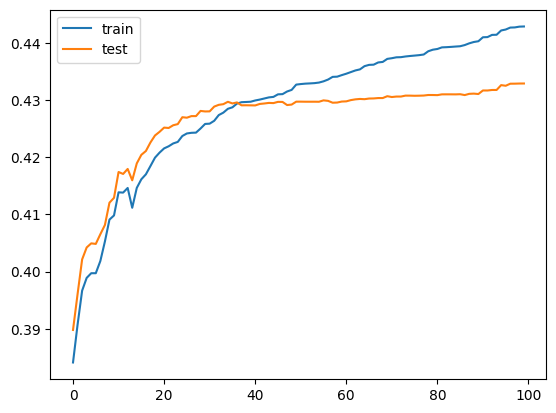

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.38173	validation_1-aucpr:0.38672
[1]	validation_0-aucpr:0.39531	validation_1-aucpr:0.39823
[2]	validation_0-aucpr:0.39653	validation_1-aucpr:0.39999
[3]	validation_0-aucpr:0.39854	validation_1-aucpr:0.40114
[4]	validation_0-aucpr:0.40009	validation_1-aucpr:0.40258
[5]	validation_0-aucpr:0.40178	validation_1-aucpr:0.40476
[6]	validation_0-aucpr:0.40483	validation_1-aucpr:0.40736
[7]	validation_0-aucpr:0.40688	validation_1-aucpr:0.41012
[8]	validation_0-aucpr:0.40771	validation_1-aucpr:0.41107
[9]	validation_0-aucpr:0.41458	validation_1-aucpr:0.41761
[10]	validation_0-aucpr:0.41494	validation_1-aucpr:0.41796
[11]	validation_0-aucpr:0.41573	validation_1-aucpr:0.41904
[12]	validation_0-aucpr:0.41615	validation_1-aucpr:0.41933
[13]	validation_0-aucpr:0.41238	validation_1-aucpr:0.41618
[14]	validation_0-aucpr:0.41310	validation_1-aucpr:0.41593
[15]	validation_0-aucpr:0.41740	validation_1-aucpr:0.42065
[16]	validation_0-aucpr:0.41832	validation_1-aucpr:0.42085
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.38173121363421614, 0.3953115426122757, 0.3965323021493239, 0.3985363494023243, 0.40008888351913946, 0.40177816789911774, 0.4048284412454748, 0.4068786142530648, 0.4077071422570489, 0.4145797123958958, 0.41493550929166945, 0.4157306700141157, 0.4161501242114514, 0.41237549730990364, 0.4131006999930413, 0.4174028989674267, 0.4183195197250715, 0.41909510569392516, 0.41921628507303793, 0.41937813207589086, 0.4201268350465426, 0.42038201320070767, 0.4208473751422686, 0.4210941819468254, 0.42135636549577693, 0.4221078052911518, 0.423668776605599, 0.4237039888564977, 0.4270496115324143, 0.42728495192873545, 0.42746022351011254, 0.4279815966784589, 0.4281714048417218, 0.4292151815591422, 0.42966594203175945, 0.4297209354779787, 0.4302938583461094, 0.4303212082856476, 0.43090710248383274, 0.4310461104680356, 0.43152391516759525, 0.4316990252898983, 0.43317482618828773, 0.43343459362592945, 0.43364043730480334, 0.4338850501175254, 0.4352214215676651, 0.

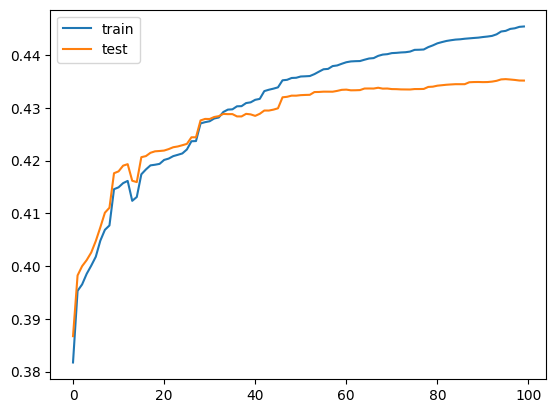

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.38614	validation_1-aucpr:0.37044
[1]	validation_0-aucpr:0.39868	validation_1-aucpr:0.38135
[2]	validation_0-aucpr:0.40121	validation_1-aucpr:0.38395
[3]	validation_0-aucpr:0.40342	validation_1-aucpr:0.38587
[4]	validation_0-aucpr:0.40427	validation_1-aucpr:0.38640
[5]	validation_0-aucpr:0.40749	validation_1-aucpr:0.38809
[6]	validation_0-aucpr:0.41037	validation_1-aucpr:0.39089
[7]	validation_0-aucpr:0.41173	validation_1-aucpr:0.39149
[8]	validation_0-aucpr:0.41277	validation_1-aucpr:0.39290
[9]	validation_0-aucpr:0.42113	validation_1-aucpr:0.40202
[10]	validation_0-aucpr:0.42144	validation_1-aucpr:0.40237
[11]	validation_0-aucpr:0.42222	validation_1-aucpr:0.40277
[12]	validation_0-aucpr:0.42326	validation_1-aucpr:0.40344
[13]	validation_0-aucpr:0.42459	validation_1-aucpr:0.40418
[14]	validation_0-aucpr:0.42535	validation_1-aucpr:0.40536
[15]	validation_0-aucpr:0.42595	validation_1-aucpr:0.40564
[16]	validation_0-aucpr:0.42649	validation_1-aucpr:0.40595
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.3861397414645861, 0.3986777400868357, 0.40121477235898106, 0.4034186185143617, 0.4042695063352906, 0.40748583037876784, 0.41037448491921175, 0.411730900713362, 0.41276724329117886, 0.42112647779363155, 0.4214388536557255, 0.4222229479157161, 0.4232605600788618, 0.42458897295820963, 0.42535208437863364, 0.4259517379515587, 0.426491882755944, 0.4266908044527643, 0.427264700105988, 0.42739383884369797, 0.4277852440025283, 0.42783941988831126, 0.4291155866782167, 0.42910584717686123, 0.4298026504817322, 0.43052563092356017, 0.43130734951648897, 0.43131960223088545, 0.431375817437907, 0.43143494373562524, 0.4322461495384586, 0.43241640374026724, 0.4331563085622139, 0.433289558790854, 0.4338580267782539, 0.43411896429596764, 0.43423638437891265, 0.43437849199755724, 0.4343937318146304, 0.4346433305894952, 0.43533916313668836, 0.43542747811312194, 0.4357346327473669, 0.43651503723077745, 0.4366374578527715, 0.4367842208993739, 0.4368771870243398, 0.4

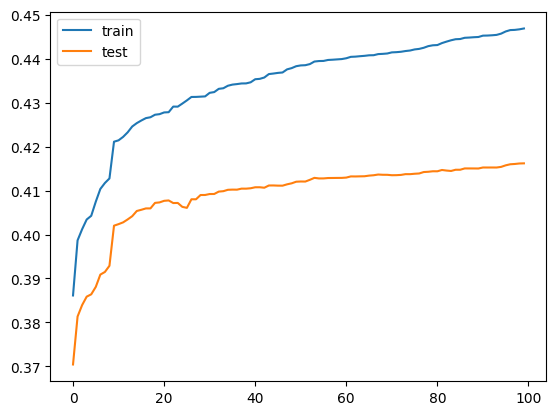

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.38689	validation_1-aucpr:0.38893
[1]	validation_0-aucpr:0.39698	validation_1-aucpr:0.39810
[2]	validation_0-aucpr:0.39825	validation_1-aucpr:0.40085
[3]	validation_0-aucpr:0.40007	validation_1-aucpr:0.40291
[4]	validation_0-aucpr:0.40072	validation_1-aucpr:0.40321
[5]	validation_0-aucpr:0.40240	validation_1-aucpr:0.40454
[6]	validation_0-aucpr:0.40271	validation_1-aucpr:0.40476
[7]	validation_0-aucpr:0.40545	validation_1-aucpr:0.40730
[8]	validation_0-aucpr:0.41421	validation_1-aucpr:0.41445
[9]	validation_0-aucpr:0.41418	validation_1-aucpr:0.41415
[10]	validation_0-aucpr:0.41512	validation_1-aucpr:0.41492
[11]	validation_0-aucpr:0.41563	validation_1-aucpr:0.41520
[12]	validation_0-aucpr:0.41682	validation_1-aucpr:0.41662
[13]	validation_0-aucpr:0.41796	validation_1-aucpr:0.41746
[14]	validation_0-aucpr:0.41819	validation_1-aucpr:0.41777
[15]	validation_0-aucpr:0.41964	validation_1-aucpr:0.41904
[16]	validation_0-aucpr:0.42139	validation_1-aucpr:0.41999
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.3868928790967535, 0.39698293118281336, 0.39825383159664696, 0.4000699010554733, 0.4007157465342642, 0.4023957684948645, 0.402705240887519, 0.4054453726957425, 0.41421045211738367, 0.41417625716643125, 0.4151150616131182, 0.4156265688896718, 0.4168234629315063, 0.41795746000426515, 0.41818898094831863, 0.4196413942714808, 0.4213874733024723, 0.4221213599573524, 0.4229399387764594, 0.4233279080461681, 0.4244223147784209, 0.42458916600229124, 0.42532860321257915, 0.42580872884278, 0.42643001885012854, 0.42648690986241083, 0.4276238338991096, 0.4276883064208068, 0.42843683456593407, 0.42879920527415366, 0.42892657066420586, 0.42898447713269794, 0.4291097489389119, 0.42916382294905747, 0.4292707833483299, 0.42961569299911145, 0.4299224777979551, 0.42996204536762295, 0.4302879663421477, 0.4304564930967963, 0.4306007871857032, 0.4309310609789684, 0.4310971044922585, 0.43186242707477335, 0.4320716456545948, 0.4321143754298462, 0.4321911963504706, 0.43

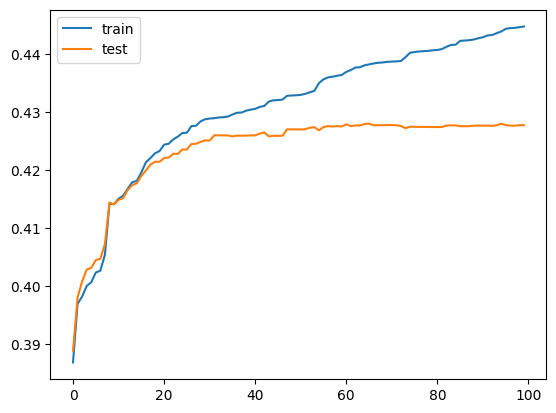

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.47894	validation_1-aucpr:0.47534
[1]	validation_0-aucpr:0.49265	validation_1-aucpr:0.48860
[2]	validation_0-aucpr:0.49934	validation_1-aucpr:0.49505
[3]	validation_0-aucpr:0.50746	validation_1-aucpr:0.50318
[4]	validation_0-aucpr:0.51464	validation_1-aucpr:0.51021
[5]	validation_0-aucpr:0.51715	validation_1-aucpr:0.51314
[6]	validation_0-aucpr:0.52115	validation_1-aucpr:0.51707
[7]	validation_0-aucpr:0.52133	validation_1-aucpr:0.51600
[8]	validation_0-aucpr:0.52549	validation_1-aucpr:0.52021
[9]	validation_0-aucpr:0.52832	validation_1-aucpr:0.52285
[10]	validation_0-aucpr:0.52978	validation_1-aucpr:0.52478
[11]	validation_0-aucpr:0.53558	validation_1-aucpr:0.53087
[12]	validation_0-aucpr:0.53881	validation_1-aucpr:0.53406
[13]	validation_0-aucpr:0.54104	validation_1-aucpr:0.53605
[14]	validation_0-aucpr:0.54342	validation_1-aucpr:0.53805
[15]	validation_0-aucpr:0.54717	validation_1-aucpr:0.54209
[16]	validation_0-aucpr:0.54836	validation_1-aucpr:0.54315
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.47893596618414513, 0.4926474266774453, 0.4993383264855071, 0.5074550358383755, 0.5146392404595772, 0.5171504780080342, 0.5211475711494359, 0.5213252135902212, 0.5254856509371024, 0.5283221640817292, 0.5297784650870325, 0.5355752804750642, 0.5388099447820525, 0.5410419184010318, 0.5434150050926523, 0.5471741222845484, 0.5483585093693806, 0.5509971143049955, 0.5516477639169083, 0.5527111703708955, 0.554976437328947, 0.5571166158544957, 0.5579646411815794, 0.5587112901342322, 0.5605069172244731, 0.5618184641013841, 0.5627593348083172, 0.563861417637103, 0.5634964171906789, 0.563553924633931, 0.5650996534670191, 0.5654700775316922, 0.5658401491549289, 0.5673615838217019, 0.5689731023493199, 0.5703578230126808, 0.570732762856439, 0.5710343847326408, 0.5712240364415628, 0.5712983951282444, 0.5720014556137062, 0.5721427247446128, 0.5726473642221361, 0.5729904760991031, 0.5740337185283517, 0.5741024671393834, 0.5742093132243633, 0.5745229217998244, 0.

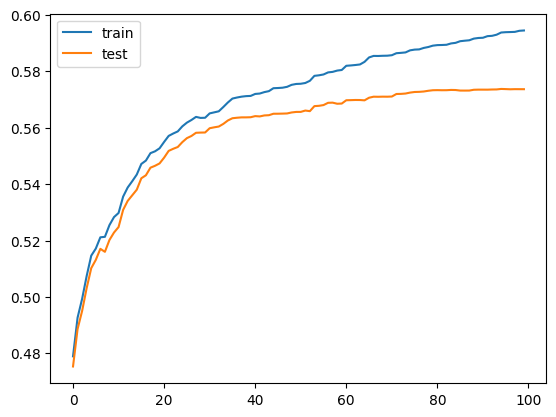

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.47713	validation_1-aucpr:0.47932
[1]	validation_0-aucpr:0.49182	validation_1-aucpr:0.49284
[2]	validation_0-aucpr:0.49736	validation_1-aucpr:0.49861
[3]	validation_0-aucpr:0.50504	validation_1-aucpr:0.50744
[4]	validation_0-aucpr:0.51083	validation_1-aucpr:0.51262
[5]	validation_0-aucpr:0.51332	validation_1-aucpr:0.51497
[6]	validation_0-aucpr:0.51678	validation_1-aucpr:0.51876
[7]	validation_0-aucpr:0.51584	validation_1-aucpr:0.51927
[8]	validation_0-aucpr:0.51943	validation_1-aucpr:0.52276
[9]	validation_0-aucpr:0.52117	validation_1-aucpr:0.52461
[10]	validation_0-aucpr:0.52250	validation_1-aucpr:0.52568
[11]	validation_0-aucpr:0.52420	validation_1-aucpr:0.52744
[12]	validation_0-aucpr:0.52919	validation_1-aucpr:0.53216
[13]	validation_0-aucpr:0.53365	validation_1-aucpr:0.53671
[14]	validation_0-aucpr:0.53591	validation_1-aucpr:0.53897
[15]	validation_0-aucpr:0.52696	validation_1-aucpr:0.53099
[16]	validation_0-aucpr:0.53563	validation_1-aucpr:0.53944
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.47712788128934847, 0.4918249825665658, 0.4973619830622447, 0.5050351994646011, 0.5108286417434827, 0.5133249381395151, 0.5167784968498489, 0.5158397961137275, 0.5194292847564085, 0.5211694299969591, 0.5224998329427137, 0.5241978737341438, 0.5291864253847204, 0.5336486673119396, 0.5359085643271513, 0.5269623162862752, 0.5356305121791387, 0.5365730854192454, 0.5379550317241478, 0.5391127485938784, 0.5413874199411524, 0.5430412409432698, 0.5435257855917408, 0.5473468647923347, 0.548267016757109, 0.5497873749416855, 0.5499330449472585, 0.5535882357712119, 0.5544639704916278, 0.5544831956764876, 0.5546136769405703, 0.5569678081903997, 0.5601625969413327, 0.5612914138862154, 0.5628997878357305, 0.5639288628050478, 0.5648085798038078, 0.5650165632694581, 0.5668291604899063, 0.5679527790434835, 0.568095631839721, 0.568355114429975, 0.5690703929228518, 0.5692518506231443, 0.5699200634138268, 0.5700289292376655, 0.5704492644524536, 0.570484830302449, 0.

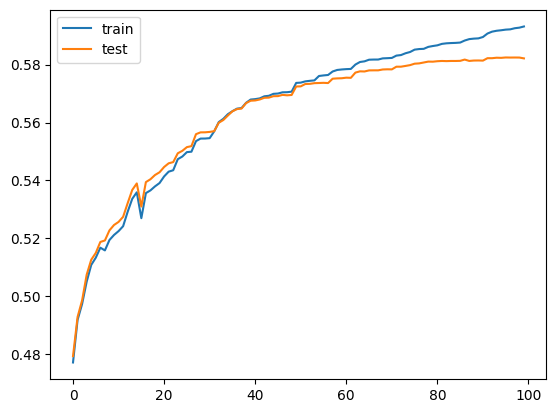

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.47712	validation_1-aucpr:0.48834
[1]	validation_0-aucpr:0.49259	validation_1-aucpr:0.50257
[2]	validation_0-aucpr:0.50044	validation_1-aucpr:0.50969
[3]	validation_0-aucpr:0.50429	validation_1-aucpr:0.51291
[4]	validation_0-aucpr:0.50963	validation_1-aucpr:0.51815
[5]	validation_0-aucpr:0.51473	validation_1-aucpr:0.52309
[6]	validation_0-aucpr:0.51663	validation_1-aucpr:0.52530
[7]	validation_0-aucpr:0.51820	validation_1-aucpr:0.52552
[8]	validation_0-aucpr:0.52078	validation_1-aucpr:0.52821
[9]	validation_0-aucpr:0.52211	validation_1-aucpr:0.52933
[10]	validation_0-aucpr:0.52345	validation_1-aucpr:0.53032
[11]	validation_0-aucpr:0.52491	validation_1-aucpr:0.53188
[12]	validation_0-aucpr:0.52887	validation_1-aucpr:0.53629
[13]	validation_0-aucpr:0.53277	validation_1-aucpr:0.53997
[14]	validation_0-aucpr:0.53510	validation_1-aucpr:0.54228
[15]	validation_0-aucpr:0.53665	validation_1-aucpr:0.54399
[16]	validation_0-aucpr:0.53863	validation_1-aucpr:0.54592
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.4771167309334507, 0.49259485361920274, 0.5004428350248598, 0.5042933545979853, 0.5096269458885183, 0.5147278237263474, 0.516626594742013, 0.5181958802362933, 0.5207789287863905, 0.5221090305791662, 0.523454069445755, 0.5249143897562492, 0.5288679528260034, 0.5327675737682621, 0.5351005844137138, 0.5366470994290604, 0.5386264593677351, 0.5447759118918115, 0.5474145248708592, 0.548619816960363, 0.5488305712947453, 0.5549077426635199, 0.5548422300990891, 0.5581048761123909, 0.5598332119592175, 0.5599776690669216, 0.5602140242681368, 0.5601199911228593, 0.5602617965246981, 0.5604236284157396, 0.5639781323573972, 0.5644933824640908, 0.5650413539569958, 0.5652090155446897, 0.566060747288589, 0.5662473701458542, 0.566477372054529, 0.5665768749237982, 0.5668837621621389, 0.56777348504526, 0.5683115596534289, 0.5685260952727192, 0.5692062430027699, 0.5693060924383629, 0.5696327867433404, 0.5712470029074765, 0.5713025947306031, 0.572089247823902, 0.5724

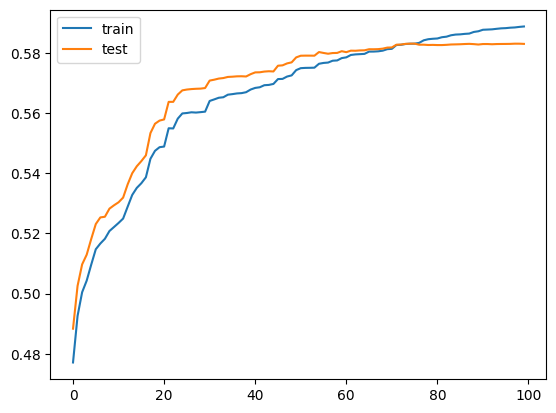

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.48193	validation_1-aucpr:0.46367
[1]	validation_0-aucpr:0.49470	validation_1-aucpr:0.47651
[2]	validation_0-aucpr:0.50182	validation_1-aucpr:0.48383
[3]	validation_0-aucpr:0.50864	validation_1-aucpr:0.49055
[4]	validation_0-aucpr:0.51459	validation_1-aucpr:0.49577
[5]	validation_0-aucpr:0.51790	validation_1-aucpr:0.49919
[6]	validation_0-aucpr:0.52111	validation_1-aucpr:0.50177
[7]	validation_0-aucpr:0.52287	validation_1-aucpr:0.50555
[8]	validation_0-aucpr:0.52444	validation_1-aucpr:0.50709
[9]	validation_0-aucpr:0.52612	validation_1-aucpr:0.50836
[10]	validation_0-aucpr:0.52757	validation_1-aucpr:0.50963
[11]	validation_0-aucpr:0.52934	validation_1-aucpr:0.51125
[12]	validation_0-aucpr:0.53206	validation_1-aucpr:0.51371
[13]	validation_0-aucpr:0.53442	validation_1-aucpr:0.51596
[14]	validation_0-aucpr:0.51802	validation_1-aucpr:0.50262
[15]	validation_0-aucpr:0.53661	validation_1-aucpr:0.51715
[16]	validation_0-aucpr:0.54143	validation_1-aucpr:0.52200
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.4819275056738808, 0.4946993185738249, 0.5018237190780154, 0.5086424045788549, 0.5145907603353701, 0.517902647360123, 0.5211057152065784, 0.5228677726066249, 0.5244356755916965, 0.5261225611636905, 0.527566268497805, 0.5293446754953997, 0.5320563489326279, 0.5344207244667445, 0.5180234692410738, 0.5366084430069245, 0.5414277258270833, 0.5438012000557166, 0.5466108068921702, 0.5499607445138972, 0.5509530681544293, 0.5518688532220333, 0.557485273221421, 0.5577611859987224, 0.5583840807956516, 0.5589284998885251, 0.5631057277173788, 0.5633643842110148, 0.5675417226036116, 0.5676230294876801, 0.5676466414456078, 0.568407805671683, 0.569001748865667, 0.5730708210008086, 0.573388927252436, 0.574209923012485, 0.5743025016285287, 0.5743279868911113, 0.5758812526530891, 0.5760022311166763, 0.5663794800976426, 0.5752031961376104, 0.5770578825907297, 0.5783916815840665, 0.5793373885724811, 0.5798796772146929, 0.5800901842415, 0.5802367601656209, 0.5805563

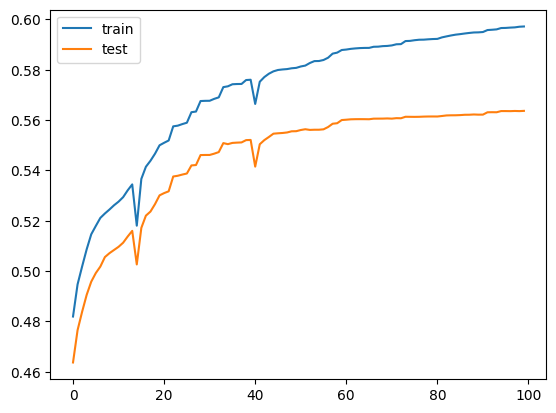

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.47633	validation_1-aucpr:0.47968
[1]	validation_0-aucpr:0.49227	validation_1-aucpr:0.49527
[2]	validation_0-aucpr:0.49844	validation_1-aucpr:0.50164
[3]	validation_0-aucpr:0.50498	validation_1-aucpr:0.50803
[4]	validation_0-aucpr:0.50750	validation_1-aucpr:0.51055
[5]	validation_0-aucpr:0.51380	validation_1-aucpr:0.51707
[6]	validation_0-aucpr:0.51680	validation_1-aucpr:0.52007
[7]	validation_0-aucpr:0.51780	validation_1-aucpr:0.52074
[8]	validation_0-aucpr:0.52356	validation_1-aucpr:0.52584
[9]	validation_0-aucpr:0.52658	validation_1-aucpr:0.52877
[10]	validation_0-aucpr:0.53128	validation_1-aucpr:0.53324
[11]	validation_0-aucpr:0.53714	validation_1-aucpr:0.53846
[12]	validation_0-aucpr:0.53855	validation_1-aucpr:0.53950
[13]	validation_0-aucpr:0.54110	validation_1-aucpr:0.54183
[14]	validation_0-aucpr:0.54434	validation_1-aucpr:0.54469
[15]	validation_0-aucpr:0.54551	validation_1-aucpr:0.54547
[16]	validation_0-aucpr:0.54606	validation_1-aucpr:0.54548
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.4763262721809766, 0.4922745685849105, 0.49844048138175334, 0.5049772712248922, 0.5075045291071082, 0.5137980069501258, 0.516799762222249, 0.5178016643098148, 0.5235573921911783, 0.5265774803148727, 0.5312836338351288, 0.5371419255107733, 0.5385476174293273, 0.5411038013640564, 0.5443350681760594, 0.5455105981244438, 0.546056947762007, 0.5485580197379312, 0.5499503611825319, 0.5513093802771504, 0.5560333203623569, 0.5571014015586376, 0.5589041570363306, 0.5607033067621747, 0.5610247378253548, 0.561558661132356, 0.5624556665178545, 0.5625620805809062, 0.5656763385151542, 0.5657383417594347, 0.5661370571031275, 0.5679163172891125, 0.5680737896472364, 0.568589106774438, 0.5705599803978862, 0.5706455959163687, 0.5713210871939335, 0.5711068566753047, 0.5712943800067932, 0.5713704289713964, 0.5719273505336575, 0.5720969003159856, 0.5721358564175856, 0.5736828162893641, 0.5740389469240879, 0.5766380549563022, 0.5767046604942138, 0.5769226999656742, 0.

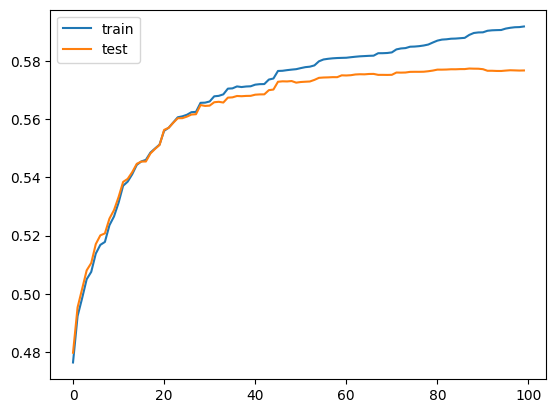

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.81520	validation_1-aucpr:0.81246
[1]	validation_0-aucpr:0.83642	validation_1-aucpr:0.83177
[2]	validation_0-aucpr:0.85035	validation_1-aucpr:0.84544
[3]	validation_0-aucpr:0.85268	validation_1-aucpr:0.84810
[4]	validation_0-aucpr:0.86680	validation_1-aucpr:0.86243
[5]	validation_0-aucpr:0.88137	validation_1-aucpr:0.87741
[6]	validation_0-aucpr:0.88813	validation_1-aucpr:0.88381
[7]	validation_0-aucpr:0.90679	validation_1-aucpr:0.90206
[8]	validation_0-aucpr:0.91464	validation_1-aucpr:0.90994
[9]	validation_0-aucpr:0.91903	validation_1-aucpr:0.91418
[10]	validation_0-aucpr:0.92874	validation_1-aucpr:0.92434
[11]	validation_0-aucpr:0.93516	validation_1-aucpr:0.93083
[12]	validation_0-aucpr:0.94004	validation_1-aucpr:0.93549
[13]	validation_0-aucpr:0.94540	validation_1-aucpr:0.94009
[14]	validation_0-aucpr:0.94773	validation_1-aucpr:0.94238
[15]	validation_0-aucpr:0.95227	validation_1-aucpr:0.94699
[16]	validation_0-aucpr:0.95410	validation_1-aucpr:0.94895
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.8151951369047689, 0.8364154922380337, 0.8503457811586902, 0.8526783596886293, 0.8668047209409258, 0.8813695361195366, 0.8881251787182901, 0.9067920528339318, 0.9146369345599441, 0.919034215853796, 0.9287365833817164, 0.9351575861412182, 0.94004478705698, 0.9454005026213332, 0.9477301115211046, 0.9522748213324553, 0.9541023936131853, 0.9559642160884663, 0.9567173909427991, 0.9600448966706334, 0.9622353419007879, 0.9635267044810714, 0.9666989684187004, 0.9681307043734884, 0.9685578964312659, 0.969986373714269, 0.9703755954122193, 0.9713429548923137, 0.9719519147470428, 0.9733806791706803, 0.9740670545833451, 0.974391513725638, 0.9752433795891674, 0.976018256286592, 0.9766191136966222, 0.9772189807653381, 0.9778814372005495, 0.9785829715520287, 0.9788433094330632, 0.979295794195031, 0.979342955419597, 0.9794961193591025, 0.9800422149864104, 0.9805645387682589, 0.9808621091382194, 0.9811592491649797, 0.9813851356770535, 0.9815476951399079, 0.98162

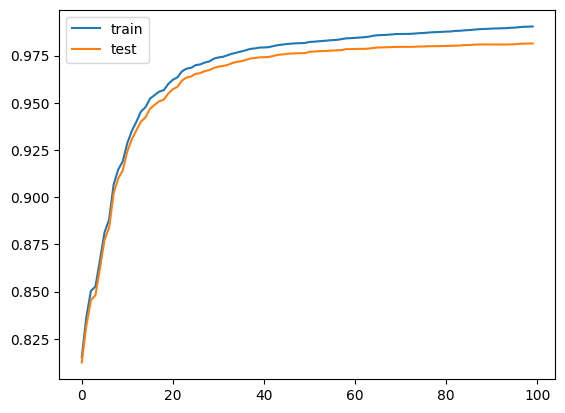

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.81449	validation_1-aucpr:0.81879
[1]	validation_0-aucpr:0.83535	validation_1-aucpr:0.83871
[2]	validation_0-aucpr:0.85002	validation_1-aucpr:0.85247
[3]	validation_0-aucpr:0.86323	validation_1-aucpr:0.86575
[4]	validation_0-aucpr:0.87646	validation_1-aucpr:0.87884
[5]	validation_0-aucpr:0.88029	validation_1-aucpr:0.88268
[6]	validation_0-aucpr:0.88571	validation_1-aucpr:0.88789
[7]	validation_0-aucpr:0.90032	validation_1-aucpr:0.90111
[8]	validation_0-aucpr:0.90807	validation_1-aucpr:0.90941
[9]	validation_0-aucpr:0.91926	validation_1-aucpr:0.91930
[10]	validation_0-aucpr:0.92702	validation_1-aucpr:0.92671
[11]	validation_0-aucpr:0.93528	validation_1-aucpr:0.93492
[12]	validation_0-aucpr:0.94305	validation_1-aucpr:0.94269
[13]	validation_0-aucpr:0.94614	validation_1-aucpr:0.94559
[14]	validation_0-aucpr:0.94896	validation_1-aucpr:0.94840
[15]	validation_0-aucpr:0.95267	validation_1-aucpr:0.95180
[16]	validation_0-aucpr:0.95651	validation_1-aucpr:0.95601
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.8144921167033656, 0.8353510161736212, 0.8500167934594256, 0.8632345834083915, 0.8764615619967131, 0.8802853387508559, 0.8857072296051579, 0.9003225010513032, 0.9080716496267977, 0.9192611234073073, 0.9270168179077806, 0.935283500150463, 0.9430454276466536, 0.9461404418894309, 0.9489565495312566, 0.9526725494665502, 0.956514694895576, 0.9584342452280055, 0.96060245378915, 0.9630341429182899, 0.9644640442866113, 0.965915538852029, 0.9669785155043445, 0.9688082960985731, 0.9707305582305229, 0.971917746864933, 0.9725938247044361, 0.9727336787826032, 0.9742766462568074, 0.9752645140731864, 0.9759293700836636, 0.976279840017924, 0.9771026326349286, 0.9776952532505196, 0.9782619461360909, 0.9784670816815315, 0.9795729290940873, 0.9797604244487521, 0.9800309041631974, 0.9802328601178769, 0.9804354052739691, 0.9807481827361545, 0.9808623832844543, 0.9810714059779393, 0.9813170003986973, 0.9814071616695436, 0.9814909626617696, 0.9818197952320787, 0.9823

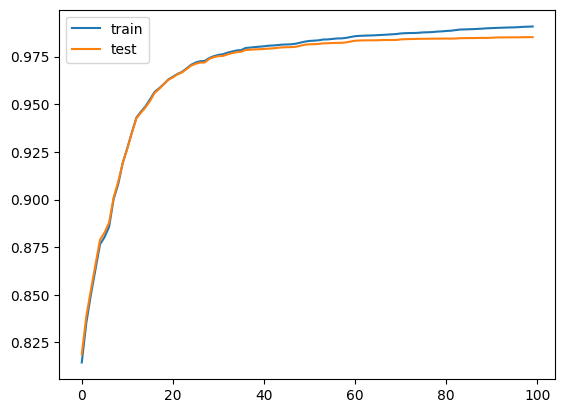

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.81394	validation_1-aucpr:0.81949
[1]	validation_0-aucpr:0.83430	validation_1-aucpr:0.83868
[2]	validation_0-aucpr:0.84778	validation_1-aucpr:0.85180
[3]	validation_0-aucpr:0.85490	validation_1-aucpr:0.85868
[4]	validation_0-aucpr:0.87022	validation_1-aucpr:0.87372
[5]	validation_0-aucpr:0.87783	validation_1-aucpr:0.88076
[6]	validation_0-aucpr:0.89242	validation_1-aucpr:0.89452
[7]	validation_0-aucpr:0.90554	validation_1-aucpr:0.90725
[8]	validation_0-aucpr:0.91193	validation_1-aucpr:0.91328
[9]	validation_0-aucpr:0.91904	validation_1-aucpr:0.91995
[10]	validation_0-aucpr:0.92726	validation_1-aucpr:0.92808
[11]	validation_0-aucpr:0.93391	validation_1-aucpr:0.93409
[12]	validation_0-aucpr:0.93839	validation_1-aucpr:0.93821
[13]	validation_0-aucpr:0.94307	validation_1-aucpr:0.94323
[14]	validation_0-aucpr:0.94457	validation_1-aucpr:0.94452
[15]	validation_0-aucpr:0.95005	validation_1-aucpr:0.94997
[16]	validation_0-aucpr:0.95240	validation_1-aucpr:0.95247
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.8139377642168558, 0.8343032544645065, 0.8477750109015461, 0.854900666382833, 0.8702152268668243, 0.8778310210198934, 0.8924243379562917, 0.905541783582989, 0.9119316494779648, 0.9190386356582322, 0.9272606019046064, 0.9339134956968852, 0.9383881459475303, 0.9430694268322454, 0.9445690422046004, 0.9500546525724307, 0.9523984370401196, 0.955527403955343, 0.9573812143773761, 0.9587974062417862, 0.9616111877011975, 0.9643647387602371, 0.9661072492486041, 0.9670573745194714, 0.9680576591534148, 0.9693784556901492, 0.9701328205404212, 0.9710125310703975, 0.9714406750692179, 0.9722557598247648, 0.9736714618149653, 0.9738777876882803, 0.9744807425230759, 0.9754735128832395, 0.975765114135663, 0.9762355914025288, 0.9770081056852787, 0.9771250882856158, 0.9775883864661743, 0.9782882952885177, 0.9791370159493177, 0.9797661285853119, 0.9806856731137584, 0.9809757715972361, 0.9814613431937352, 0.9817822470190244, 0.9819506968425796, 0.9824127893758804, 0.9

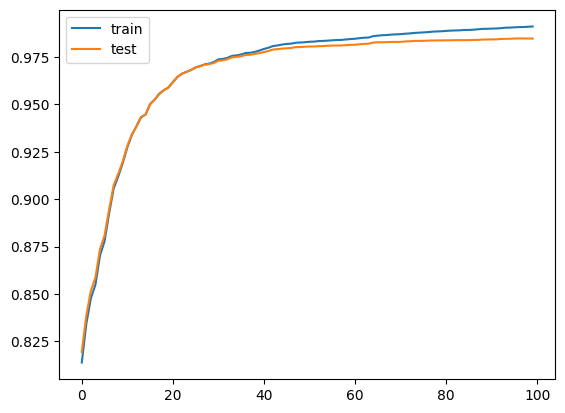

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.81655	validation_1-aucpr:0.80684
[1]	validation_0-aucpr:0.83694	validation_1-aucpr:0.82896
[2]	validation_0-aucpr:0.85425	validation_1-aucpr:0.84689
[3]	validation_0-aucpr:0.86488	validation_1-aucpr:0.85786
[4]	validation_0-aucpr:0.87352	validation_1-aucpr:0.86724
[5]	validation_0-aucpr:0.87911	validation_1-aucpr:0.87105
[6]	validation_0-aucpr:0.88699	validation_1-aucpr:0.87981
[7]	validation_0-aucpr:0.90485	validation_1-aucpr:0.90049
[8]	validation_0-aucpr:0.91418	validation_1-aucpr:0.90988
[9]	validation_0-aucpr:0.92080	validation_1-aucpr:0.91700
[10]	validation_0-aucpr:0.92694	validation_1-aucpr:0.92322
[11]	validation_0-aucpr:0.93714	validation_1-aucpr:0.93367
[12]	validation_0-aucpr:0.93919	validation_1-aucpr:0.93561
[13]	validation_0-aucpr:0.94244	validation_1-aucpr:0.93848
[14]	validation_0-aucpr:0.94560	validation_1-aucpr:0.94161
[15]	validation_0-aucpr:0.94946	validation_1-aucpr:0.94548
[16]	validation_0-aucpr:0.95183	validation_1-aucpr:0.94789
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.8165543198415701, 0.8369363452215132, 0.8542498551205208, 0.8648790572899957, 0.8735170383947015, 0.8791068962855749, 0.8869865752409177, 0.9048536335935122, 0.9141837417701753, 0.9208031142260358, 0.9269402145064531, 0.9371409325203711, 0.9391948148816172, 0.9424401701608962, 0.9456023859157368, 0.9494609689141809, 0.9518335570395801, 0.9551731916292482, 0.9571300548628907, 0.9614870466691026, 0.9636711824365188, 0.9645004190557183, 0.9669334038505436, 0.9682113702062195, 0.9699078659343469, 0.9707484334884589, 0.9724100928541545, 0.9728389417965879, 0.9739535615519729, 0.9742424506399139, 0.9755275847856425, 0.9763353354432333, 0.9773405280061734, 0.9782007615633291, 0.978728726420155, 0.9791422034745337, 0.9797228292627096, 0.9800952010134636, 0.9805333995835112, 0.9810040791094281, 0.9811323511098862, 0.9815090681176927, 0.9817008875676106, 0.9819569164956533, 0.9821197718194209, 0.9821965889451104, 0.9827711441446695, 0.98295287401658, 0.

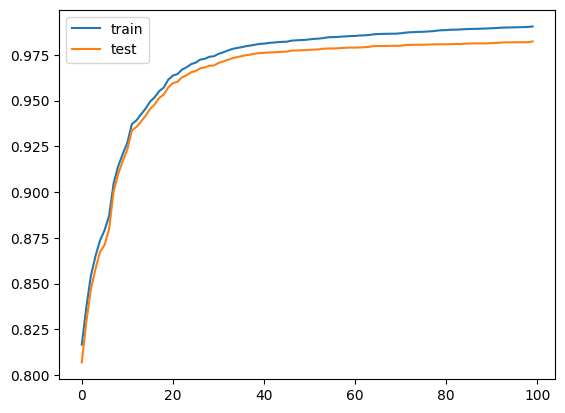

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.81621	validation_1-aucpr:0.81498
[1]	validation_0-aucpr:0.83780	validation_1-aucpr:0.83837
[2]	validation_0-aucpr:0.85540	validation_1-aucpr:0.85652
[3]	validation_0-aucpr:0.86552	validation_1-aucpr:0.86747
[4]	validation_0-aucpr:0.87578	validation_1-aucpr:0.87768
[5]	validation_0-aucpr:0.88876	validation_1-aucpr:0.89050
[6]	validation_0-aucpr:0.90302	validation_1-aucpr:0.90596
[7]	validation_0-aucpr:0.90892	validation_1-aucpr:0.91133
[8]	validation_0-aucpr:0.91447	validation_1-aucpr:0.91650
[9]	validation_0-aucpr:0.92048	validation_1-aucpr:0.92282
[10]	validation_0-aucpr:0.93130	validation_1-aucpr:0.93255
[11]	validation_0-aucpr:0.93514	validation_1-aucpr:0.93589
[12]	validation_0-aucpr:0.94019	validation_1-aucpr:0.94131
[13]	validation_0-aucpr:0.94414	validation_1-aucpr:0.94546
[14]	validation_0-aucpr:0.94900	validation_1-aucpr:0.94967
[15]	validation_0-aucpr:0.95178	validation_1-aucpr:0.95230
[16]	validation_0-aucpr:0.95387	validation_1-aucpr:0.95423
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.8162124757187763, 0.8377955749905042, 0.8553984224704442, 0.8655174603181054, 0.8757826873991915, 0.8887594050105455, 0.9030245517061937, 0.9089240422679362, 0.91446579402427, 0.9204766731528126, 0.9312984649836082, 0.9351361958627569, 0.9401871167917625, 0.9441414588464024, 0.9490035186636875, 0.9517761332225763, 0.953870229012433, 0.9569976077561051, 0.9585865873315067, 0.960153867779683, 0.9618031277489127, 0.9633948164278952, 0.9658349234874607, 0.9667071912674634, 0.9682509815899785, 0.9687281223018894, 0.9706908150068764, 0.9713295019496134, 0.9717845934581363, 0.9722560912264055, 0.9731131530999836, 0.9743898777828269, 0.9751702249822105, 0.9753622321930203, 0.9757377599180059, 0.9765147715075977, 0.9768129368971608, 0.9776873880565031, 0.9785703483899101, 0.9789562566490905, 0.9794522778054413, 0.9798026427129355, 0.9799054837957649, 0.9804151606075348, 0.9805408145989342, 0.9806270913672099, 0.9807878772083705, 0.9808461537379772, 0.9

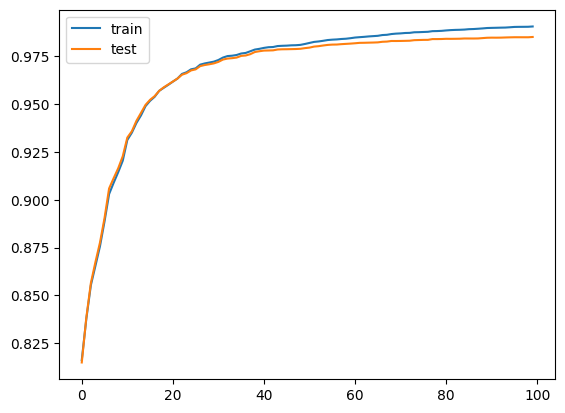

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.85250	validation_1-aucpr:0.84889
[1]	validation_0-aucpr:0.87404	validation_1-aucpr:0.87010
[2]	validation_0-aucpr:0.87710	validation_1-aucpr:0.87261
[3]	validation_0-aucpr:0.88927	validation_1-aucpr:0.88446
[4]	validation_0-aucpr:0.90155	validation_1-aucpr:0.89758
[5]	validation_0-aucpr:0.91322	validation_1-aucpr:0.90954
[6]	validation_0-aucpr:0.92063	validation_1-aucpr:0.91651
[7]	validation_0-aucpr:0.92807	validation_1-aucpr:0.92391
[8]	validation_0-aucpr:0.93581	validation_1-aucpr:0.93204
[9]	validation_0-aucpr:0.94106	validation_1-aucpr:0.93765
[10]	validation_0-aucpr:0.94482	validation_1-aucpr:0.94158
[11]	validation_0-aucpr:0.94923	validation_1-aucpr:0.94634
[12]	validation_0-aucpr:0.95284	validation_1-aucpr:0.94983
[13]	validation_0-aucpr:0.95533	validation_1-aucpr:0.95208
[14]	validation_0-aucpr:0.95876	validation_1-aucpr:0.95496
[15]	validation_0-aucpr:0.96376	validation_1-aucpr:0.95954
[16]	validation_0-aucpr:0.96723	validation_1-aucpr:0.96307
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.852495551607165, 0.8740401726460704, 0.8770962578898301, 0.8892677667827388, 0.9015463381586903, 0.9132198623842469, 0.9206324567711544, 0.9280668490031009, 0.9358089596291065, 0.9410591014299143, 0.9448156763247629, 0.9492335768396667, 0.9528375670493964, 0.9553330435659086, 0.9587569383020788, 0.9637630562799842, 0.9672284660751129, 0.969221778034407, 0.9701977916013383, 0.9708446064938059, 0.9725537411170335, 0.9727387420682108, 0.9732303858293222, 0.9746764485042846, 0.9752147617842828, 0.9766386133747086, 0.9769331301858211, 0.9773404165745726, 0.9776782748223574, 0.9780676050525021, 0.9786832084500962, 0.9793915193769842, 0.9796273585329339, 0.9798369579362975, 0.980077425469903, 0.9803175177676969, 0.9806168661400679, 0.9807988672015547, 0.9811592932147767, 0.982228203870272, 0.9826174916121476, 0.9827331991846647, 0.9830986781911405, 0.9832478185642238, 0.9834386788729895, 0.9839398084227126, 0.9845179007502163, 0.9846602423808064, 0.9

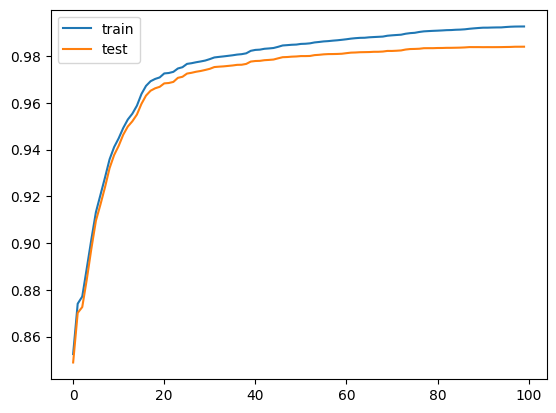

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.84942	validation_1-aucpr:0.85371
[1]	validation_0-aucpr:0.87167	validation_1-aucpr:0.87643
[2]	validation_0-aucpr:0.87510	validation_1-aucpr:0.87875
[3]	validation_0-aucpr:0.89243	validation_1-aucpr:0.89530
[4]	validation_0-aucpr:0.90505	validation_1-aucpr:0.90775
[5]	validation_0-aucpr:0.91695	validation_1-aucpr:0.91935
[6]	validation_0-aucpr:0.92862	validation_1-aucpr:0.92989
[7]	validation_0-aucpr:0.93288	validation_1-aucpr:0.93425
[8]	validation_0-aucpr:0.93882	validation_1-aucpr:0.93973
[9]	validation_0-aucpr:0.94244	validation_1-aucpr:0.94328
[10]	validation_0-aucpr:0.94526	validation_1-aucpr:0.94611
[11]	validation_0-aucpr:0.94993	validation_1-aucpr:0.95102
[12]	validation_0-aucpr:0.95501	validation_1-aucpr:0.95565
[13]	validation_0-aucpr:0.95794	validation_1-aucpr:0.95866
[14]	validation_0-aucpr:0.96077	validation_1-aucpr:0.96094
[15]	validation_0-aucpr:0.96293	validation_1-aucpr:0.96276
[16]	validation_0-aucpr:0.96547	validation_1-aucpr:0.96526
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.8494180347299851, 0.8716707971813096, 0.8750961951095734, 0.8924310337609218, 0.9050456473217752, 0.9169502221928754, 0.9286196351443815, 0.9328802796817073, 0.9388168058468589, 0.9424443905544373, 0.9452588359841921, 0.9499284718340535, 0.9550057128022681, 0.9579398541094464, 0.960773858935881, 0.9629272093020877, 0.965468680583153, 0.9666978244261726, 0.9682811366454877, 0.969943125674174, 0.970471424443294, 0.9710777455552452, 0.9717654043147136, 0.9720068965653508, 0.9735759908255704, 0.9737218139892284, 0.9747422618975297, 0.9756649938597812, 0.9768170873409578, 0.9778268545522069, 0.9788548308423323, 0.9791327380511485, 0.9795402638151279, 0.9798274043969158, 0.9801433911922364, 0.9802326941444893, 0.9804352932891096, 0.9808146829943919, 0.9811504506070089, 0.9814205635987512, 0.9818162868760615, 0.982760915573382, 0.9832507826509149, 0.9833867000897968, 0.9836658077006504, 0.9839528885452501, 0.9845896374644011, 0.9846858926940386, 0.98

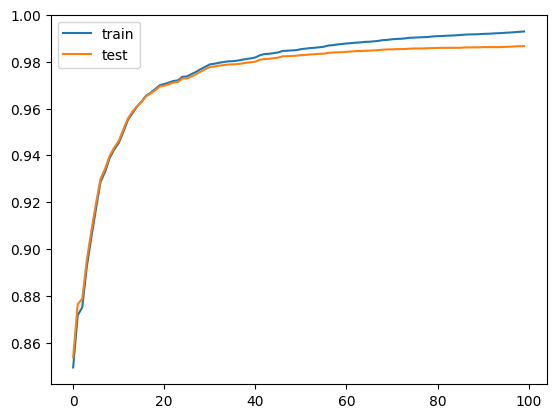

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.84880	validation_1-aucpr:0.85101
[1]	validation_0-aucpr:0.87582	validation_1-aucpr:0.87800
[2]	validation_0-aucpr:0.87903	validation_1-aucpr:0.88073
[3]	validation_0-aucpr:0.88037	validation_1-aucpr:0.88224
[4]	validation_0-aucpr:0.89240	validation_1-aucpr:0.89290
[5]	validation_0-aucpr:0.90479	validation_1-aucpr:0.90523
[6]	validation_0-aucpr:0.91798	validation_1-aucpr:0.91771
[7]	validation_0-aucpr:0.92823	validation_1-aucpr:0.92716
[8]	validation_0-aucpr:0.93568	validation_1-aucpr:0.93476
[9]	validation_0-aucpr:0.94019	validation_1-aucpr:0.94000
[10]	validation_0-aucpr:0.94502	validation_1-aucpr:0.94442
[11]	validation_0-aucpr:0.94930	validation_1-aucpr:0.94884
[12]	validation_0-aucpr:0.95454	validation_1-aucpr:0.95485
[13]	validation_0-aucpr:0.95702	validation_1-aucpr:0.95724
[14]	validation_0-aucpr:0.95847	validation_1-aucpr:0.95877
[15]	validation_0-aucpr:0.96141	validation_1-aucpr:0.96140
[16]	validation_0-aucpr:0.96527	validation_1-aucpr:0.96503
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.8488000515144266, 0.875819425137483, 0.8790306359995042, 0.8803737538667132, 0.892402984269057, 0.9047859027813455, 0.917984455333038, 0.9282313235764916, 0.9356837288910991, 0.9401926011690648, 0.9450178017292425, 0.9493048405852844, 0.9545438655010923, 0.9570215810274636, 0.958471823220786, 0.9614092784467574, 0.9652731436646226, 0.9681207117134895, 0.96948070382587, 0.9709001840476962, 0.9723439238090347, 0.9727427765827807, 0.9734973589116466, 0.9741478573674217, 0.975158279956663, 0.9757416956768223, 0.9766048074442116, 0.9769388029567728, 0.97731218853013, 0.9774751170430882, 0.9777975060502195, 0.9782635558380878, 0.9784688690451726, 0.9788051336919882, 0.9791675348812153, 0.9795983647493445, 0.980117798840776, 0.980352177324062, 0.9811006580639221, 0.9815862200901689, 0.9819474617185111, 0.9821100173733706, 0.9829652645515958, 0.983339315736294, 0.9842099023000659, 0.9845398873568448, 0.9849323300354753, 0.9850371025049461, 0.985157666

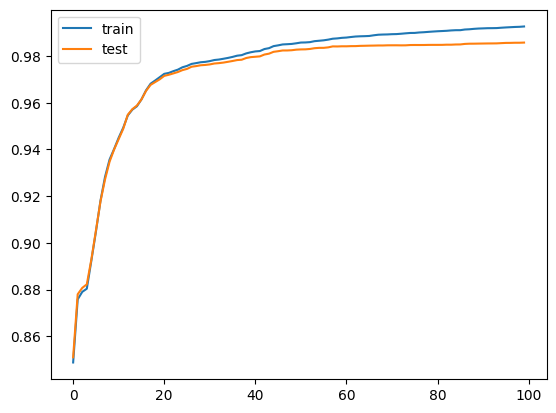

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.85417	validation_1-aucpr:0.84708
[1]	validation_0-aucpr:0.87330	validation_1-aucpr:0.86652
[2]	validation_0-aucpr:0.87785	validation_1-aucpr:0.87202
[3]	validation_0-aucpr:0.88850	validation_1-aucpr:0.88317
[4]	validation_0-aucpr:0.89384	validation_1-aucpr:0.88845
[5]	validation_0-aucpr:0.90613	validation_1-aucpr:0.90168
[6]	validation_0-aucpr:0.91404	validation_1-aucpr:0.91017
[7]	validation_0-aucpr:0.92455	validation_1-aucpr:0.92024
[8]	validation_0-aucpr:0.93351	validation_1-aucpr:0.93008
[9]	validation_0-aucpr:0.93902	validation_1-aucpr:0.93538
[10]	validation_0-aucpr:0.94380	validation_1-aucpr:0.93947
[11]	validation_0-aucpr:0.94906	validation_1-aucpr:0.94442
[12]	validation_0-aucpr:0.95351	validation_1-aucpr:0.94922
[13]	validation_0-aucpr:0.95814	validation_1-aucpr:0.95344
[14]	validation_0-aucpr:0.95955	validation_1-aucpr:0.95479
[15]	validation_0-aucpr:0.96187	validation_1-aucpr:0.95687
[16]	validation_0-aucpr:0.96442	validation_1-aucpr:0.95950
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.8541731531214698, 0.8732988376991307, 0.8778498185344412, 0.8885048641333614, 0.8938408846623943, 0.9061294359905999, 0.9140356021976309, 0.9245483137075162, 0.9335125288968938, 0.9390211737312417, 0.9437953482731878, 0.9490597428387977, 0.9535081827989942, 0.9581403769457582, 0.9595515631578563, 0.9618712267813553, 0.9644236882074869, 0.9663630356174081, 0.9682548973874369, 0.9706967959586995, 0.9718107868938678, 0.9724316326204359, 0.9730498056081617, 0.9733378485057581, 0.9736377268521113, 0.974729672071779, 0.9761928141824541, 0.976760298387647, 0.9772170407752233, 0.9775023323435428, 0.9781963286035337, 0.9784134788808901, 0.9792525537091122, 0.9797682990215867, 0.9801030125250664, 0.9805449780872466, 0.9808407897072038, 0.9810393603813551, 0.9816312377104827, 0.9817557063218787, 0.9818481239029482, 0.9821991155723593, 0.9828309932282044, 0.9829729373213241, 0.9833199779680398, 0.9836714241652794, 0.9837668568656849, 0.9839225023820796, 0

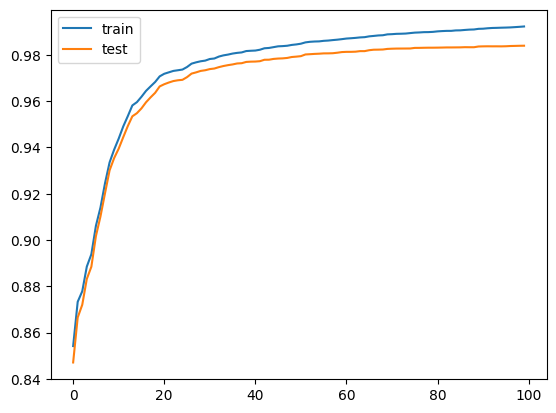

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.84944	validation_1-aucpr:0.84969
[1]	validation_0-aucpr:0.87242	validation_1-aucpr:0.87434
[2]	validation_0-aucpr:0.87602	validation_1-aucpr:0.87829
[3]	validation_0-aucpr:0.88563	validation_1-aucpr:0.88807
[4]	validation_0-aucpr:0.89421	validation_1-aucpr:0.89673
[5]	validation_0-aucpr:0.90941	validation_1-aucpr:0.91115
[6]	validation_0-aucpr:0.91733	validation_1-aucpr:0.91852
[7]	validation_0-aucpr:0.92650	validation_1-aucpr:0.92635
[8]	validation_0-aucpr:0.93319	validation_1-aucpr:0.93289
[9]	validation_0-aucpr:0.93925	validation_1-aucpr:0.93940
[10]	validation_0-aucpr:0.94376	validation_1-aucpr:0.94463
[11]	validation_0-aucpr:0.94862	validation_1-aucpr:0.94865
[12]	validation_0-aucpr:0.95150	validation_1-aucpr:0.95165
[13]	validation_0-aucpr:0.95339	validation_1-aucpr:0.95348
[14]	validation_0-aucpr:0.95656	validation_1-aucpr:0.95744
[15]	validation_0-aucpr:0.96084	validation_1-aucpr:0.96091
[16]	validation_0-aucpr:0.96348	validation_1-aucpr:0.96311
[17]	va

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))


{'validation_0': OrderedDict([('aucpr', [0.8494443139344473, 0.8724207854112915, 0.8760217390476003, 0.8856266853788427, 0.8942058319238907, 0.9094131467990826, 0.9173314035458405, 0.9264960921525994, 0.9331864909251236, 0.9392517518112864, 0.9437590029864167, 0.9486158410744436, 0.9514984199560045, 0.9533916968949563, 0.9565555608623253, 0.9608392820601678, 0.9634796163564364, 0.9650894604778424, 0.9670294738175556, 0.9688384794905707, 0.9697696221994715, 0.971176483435, 0.9718376483800242, 0.9730203975800711, 0.9732187874636226, 0.9737127538560927, 0.9742376205285997, 0.9748793952017267, 0.9757033841327543, 0.9767645589713223, 0.9774410093546508, 0.9777468336647814, 0.9782016481892278, 0.978512640576368, 0.9792492240029679, 0.9798199624589042, 0.9801577953220365, 0.9804782436030559, 0.9806279334435, 0.9812289404143103, 0.9812892105876969, 0.9814872307896528, 0.9819419715619042, 0.9822476876329276, 0.9828607938039665, 0.9833156177661642, 0.9835617747831364, 0.9838499460415177, 0.98442

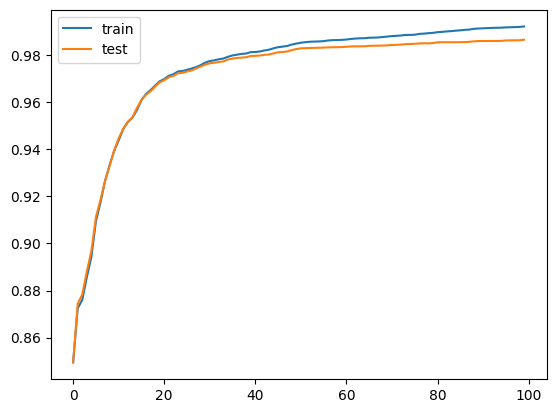

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import KFold

# Initialize evaluation dataframes
eval_df = pd.DataFrame(columns=['Classifier', 'Precision', 'Recall', 'TNR', 'TPR', 'Accuracy', 
                                'F1', 'Balanced Accuracy', 'MCC', 'Zero-One Loss', 'Fit Time', 'Predict Time'])
cm_df = pd.DataFrame(columns=['Classifier', 'Confusion Matrix', 'Classification Report'])
df_scores = pd.DataFrame(columns=['Attack Type', 'Label', 'Feature Set', 'Classifier', 'F1 Score', 
                                  'Balanced Accuracy', 'MCC', 'Precision', 'Recall', 'Other'])

nbr = 0
os.chdir('/kaggle/working/')
# Split the data into training and testing sets
list_set = [base_col,base_col+g_col,base_col+g_col+c_col,base_col+g_col+c_col+dc_col]
for elm in list_set:
    kFold=KFold(n_splits=5, random_state = 42, shuffle = True)
    for train_index,test_index in kFold.split(X):
        X_train, X_test, y_train, y_test = X[elm].iloc[train_index,:], X[elm].iloc[test_index,:], y[train_index], y[test_index]
    #X_train, X_test, y_train, y_test = train_test_split(X[elm], y, test_size=0.3, random_state=42)
    
        # Example usage:
        evalset = [(X_train, y_train), (X_test,y_test)]
        fit_start = time.time()
        clf = XGBClassifier(tree_method="auto")  # Change to "gpu_hist" if GPU acceleration is needed
        clf.fit(X_train, y_train, eval_metric="aucpr", eval_set=evalset)
        fit_time = time.time() - fit_start
        
        pred_start = time.time()
        y_pred = clf.predict(X_test)
        pred_time = time.time() - pred_start
        
        eval_xgb(clf, X_test, y_test, fit_time, pred_time,verbose=False)

        # retrieve performance metrics
        res_clf = clf.evals_result()
        print(res_clf)
        # plot learning curves
        pyplot.plot(res_clf['validation_0']["aucpr"], label='train')
        pyplot.plot(res_clf['validation_1']["aucpr"], label='test')
        # show the legend
        pyplot.legend()
        # show the plot
        
        pyplot.savefig( 'fig/'+ str(nbr)+'.png')
        pyplot.show()
        nbr = nbr + 1
        """
        # Plotting the evaluation metrics as a histogram
        metrics = eval_df.columns[1:-2]  # Selecting metrics columns excluding 'Classifier', 'Fit Time', 'Predict Time'
        values = eval_df.iloc[0, 1:-2].values  # Extracting metric values
        
        plt.figure(figsize=(10, 6))
        plt.barh(metrics, values, align='center', alpha=0.7)
        plt.xlabel('Metric Value')
        plt.title(f'Evaluation Metrics for {eval_df.iloc[0, 0]}')
        plt.xlim(0, 1)  # Assuming metrics are between 0 and 1 for clarity
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.show()
        """

In [14]:

tmp_df = pd.DataFrame(columns=['Classifier', 'Precision', 'Recall', 'TNR', 'TPR', 'Accuracy', 
                                'F1', 'Balanced Accuracy', 'MCC', 'Zero-One Loss', 'Fit Time', 'Predict Time'])
tmp_df.loc[0] = eval_df.loc[:, eval_df.columns != 'Classifier'][0:5].mean()
tmp_df.loc[0,'Classifier'] = "XGBClassifier"

tmp_df.loc[1] = eval_df.loc[:, eval_df.columns != 'Classifier'][5:10].mean()
tmp_df.loc[1,'Classifier'] = "XGBClassifier"
tmp_df.loc[2] = eval_df.loc[:, eval_df.columns != 'Classifier'][10:15].mean()
tmp_df.loc[2,'Classifier'] = "XGBClassifier"
tmp_df.loc[3] = eval_df.loc[:, eval_df.columns != 'Classifier'][15:20].mean()
tmp_df.loc[3,'Classifier'] = "XGBClassifier"

/tmp/ipykernel_16/123098576.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'XGBClassifier' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tmp_df.loc[0,'Classifier'] = "XGBClassifier"


In [15]:
tmp_df

,Classifier,Precision,Recall,TNR,TPR,Accuracy,F1,Balanced Accuracy,MCC,Zero-One Loss,Fit Time,Predict Time
0,XGBClassifier,0.989876,0.991045,0.997084,0.442528,0.991045,0.990284,0.719806,0.521875,0.008955,78.673792,1.058596
1,XGBClassifier,0.990826,0.991843,0.997503,0.477688,0.991843,0.991143,0.737596,0.565229,0.008157,69.034058,1.137496
2,XGBClassifier,0.998983,0.998993,0.999854,0.920738,0.998993,0.998976,0.960296,0.952224,0.001007,147.677730,1.482612
3,XGBClassifier,0.999054,0.999063,0.999861,0.926548,0.999063,0.999048,0.963204,0.955618,0.000937,183.407559,1.763672


In [16]:
snapshot_evaldf = tmp_df.copy()
#Multiclass eval

community_df['category'] = community_df['Label'].replace(ugr_map_dict)

/tmp/ipykernel_16/3138006032.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  community_df['category'] = community_df['Label'].replace(ugr_map_dict)


In [17]:
cm_df = pd.DataFrame(columns=['Classifier', 'Confusion Matrix', 'Classification Report'])
eval_df = pd.DataFrame(columns=['Classifier', 'Precision', 'Recall', 'TNR', 'TPR', 'Accuracy', 
                                'F1', 'Balanced Accuracy', 'MCC', 'Zero-One Loss', 'Fit Time', 'Predict Time'])

In [18]:
# Load your data (replace this with your actual data loading code)
X = community_df.drop('category', axis=1)
y = community_df['category']
# Split the data into training and testing sets
list_set = [base_col,base_col+g_col,base_col+g_col+c_col,base_col+g_col+c_col+dc_col]
for elm in list_set:
    kFold=KFold(n_splits=5, random_state = 42, shuffle = True)
    for train_index,test_index in kFold.split(X):
        X_train, X_test, y_train, y_test = X[elm].iloc[train_index,:], X[elm].iloc[test_index,:], y[train_index], y[test_index]
    #X_train, X_test, y_train, y_test = train_test_split(X[elm], y, test_size=0.3, random_state=42)
    
        # Example usage:
        fit_start = time.time()
        clf = XGBClassifier(tree_method="auto")  # Change to "gpu_hist" if GPU acceleration is needed
        clf.fit(X_train, y_train)
        fit_time = time.time() - fit_start
        
        pred_start = time.time()
        y_pred = clf.predict(X_test)
        pred_time = time.time() - pred_start
        
        eval_xgb(clf, X_test, y_test, fit_time, pred_time,verbose = False)

/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_negative))
/tmp/ipykernel_16/1928500786.py:28: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((true_positive + false_positive) * (true_positive + false_negative) * (true_negative + false_positive) * (true_negative + false_neg

In [19]:
cm_df['Confusion Matrix'][0]

array([[986148,     12,   2125,     19,    841,     20],
       [   992,      8,      0,      0,      0,      0],
       [  2744,      0,   2622,      2,      3,      0],
       [   225,      0,     12,     36,    291,      0],
       [   773,      0,      0,      8,   1868,      0],
       [  1219,      0,      0,      0,      0,     32]])

In [20]:
# from cm_df to multiclass_df

multiclass_df = pd.DataFrame(columns=['anomaly-spam','dos','scan11','scan44','nerisbotnet'])
#We consider detection of attack to be well detected as long as it is not a negative in the first place
for elm in cm_df['Confusion Matrix']:
    Precision= []
    Recall = []
    list_f1 = []
    for i in range (1,len(elm[0])):
        Precision = Precision + [elm[i][i]/(elm[i][i]+elm[i][0])]
        Recall = Recall + [elm[i][i]/(elm[i][i]+elm[i][0])]
        if Precision[i-1] + Recall[i-1] == 0:
            list_f1 = list_f1 + [0]
        else:
            list_f1 = list_f1 + [2*(Precision[i-1]*Recall[i-1])/(Precision[i-1]+Recall[i-1])]
    print(list_f1)
    multiclass_df.loc[len(multiclass_df.index)] = list_f1

[0.008, 0.48863212821468505, 0.13793103448275862, 0.7073078379401743, 0.025579536370903277]
[0.00646551724137931, 0.5150144717800289, 0.10948905109489052, 0.6866306027820711, 0.027575020275750203]
[0.01104417670682731, 0.5097968721912637, 0.1288135593220339, 0.7100952380952381, 0.024271844660194174]
[0.012464046021093002, 0.48146098505810736, 0.11149825783972125, 0.6761496492595479, 0.021806853582554516]
[0.016243654822335026, 0.48783145659280785, 0.096, 0.6903474903474903, 0.015447154471544716]
[0.104, 0.46317359686742493, 0.6039783001808319, 0.7772744431861079, 0.21502797761790568]
[0.0980603448275862, 0.4663287472845764, 0.5704099821746881, 0.7979915025106219, 0.21897810218978103]
[0.08032128514056225, 0.47150817904008624, 0.5443037974683544, 0.7984790874524716, 0.2176375404530744]
[0.0660287081339713, 0.45488097434951097, 0.6062176165803109, 0.7700701480904131, 0.21573208722741433]
[0.08620689655172414, 0.471379247683082, 0.5728346456692913, 0.7915862601312235, 0.23515052888527258]

In [21]:
kf_multiclass_df = pd.DataFrame(columns=['anomaly-spam','dos','scan11','scan44','nerisbotnet'])

kf_multiclass_df.loc[0] = multiclass_df[0:5].mean()
kf_multiclass_df.loc[1] = multiclass_df[5:10].mean()
kf_multiclass_df.loc[2] = multiclass_df[10:15].mean()
kf_multiclass_df.loc[3] = multiclass_df[15:20].mean()


In [22]:
bracket_a = "{Base set, Graph, Graph community, DGC}"
ytick_brack = {0.7,0.75,0.8,0.85,0.9,0.95,1}
metrics = [('MCC','blue'),('Balanced Accuracy','orange'),('TPR','green'),('TNR','cyan')]
result_to_latex(snapshot_evaldf,kf_multiclass_df,metrics,bracket_a,"Comparison of graph community approaches with baseline on UGR16 dataset","testall")